# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
from matplotlib import rcParams

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.hyperparam as hp
import osbad.modval as modval
import osbad.stats as bstats
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.scaler import CycleScaling
from osbad.model import ModelRunner

# Import dataset

## Define filepath

In [2]:
# Define a global variable to save fig output
# The definition of PIPELINE_OUTPUT_DIR can be
# found in config.py
PIPELINE_OUTPUT_DIR = bconf.PIPELINE_OUTPUT_DIR

In [3]:
# Load only the training dataset
db_filepath = str(
    Path.cwd()
    .parent
    .joinpath("database","train_dataset_severson.db"))

## Get the cell inventory of the training dataset

In [4]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_train_dataset_sv").fetchdf()

# Get the cell index of training dataset
unique_cell_index_train = df_duckdb["cell_index"].unique()
print(f"Unique cell index: {unique_cell_index_train}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Unique cell index: ['2017-05-12_5_4C-50per_3C_CH13' '2017-05-12_5_4C-50per_3C_CH14'
 '2017-05-12_5_4C-60per_3C_CH15' '2017-05-12_5_4C-60per_3C_CH16'
 '2017-05-12_5_4C-70per_3C_CH17' '2017-05-12_5_4C-70per_3C_CH18'
 '2017-05-12_6C-40per_3C_CH25' '2017-05-12_6C-40per_3C_CH26'
 '2017-05-12_6C-50per_3C_CH27' '2017-05-12_6C-50per_3C_CH28'
 '2017-05-12_6C-60per_3C_CH29' '2017-05-12_6C-60per_3C_CH30'
 '2017-05-12_7C-40per_3C_CH37' '2017-05-12_7C-40per_3C_CH38'
 '2017-05-12_4C-80per_4C_CH5' '2017-05-12_4C-80per_4C_CH6'
 '2017-05-12_4_4C-80per_4_4C_CH7' '2017-05-12_5_4C-80per_5_4C_CH11'
 '2017-05-12_5_4C-80per_5_4C_CH12' '2017-05-12_3_6C-80per_3_6C_CH1'
 '2017-05-12_3_6C-80per_3_6C_CH2' '2017-05-12_3_6C-80per_3_6C_CH3'
 '2017-05-12_5_4C-40per_3_6C_CH19']


In [5]:
# Get the cell-ID from cell_inventory
selected_cell_label = "2017-05-12_5_4C-70per_3C_CH17"

# Create a subfolder to store fig output
# corresponding to each cell-index
selected_cell_artifacts_dir = bconf.artifacts_output_dir(
    selected_cell_label)

## Drop true labels

* Drop true outlier labels (denoted as ``outlier``) from the dataframe and select only relevant features for ML:
  * ``cell_index``: The cell-ID for data and model versioning purposes;
  * ``cycle_index``: The cycle number of each cell;
  * ``discharge_capacity``: Discharge capacity of the cell;
  * ``voltage``: Discharge voltage of the cell.

In [6]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)

Database is found in the given filepath.
Loading benchmarking dataset now...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

****************************************************************************************************


## Plot cycling data without labels

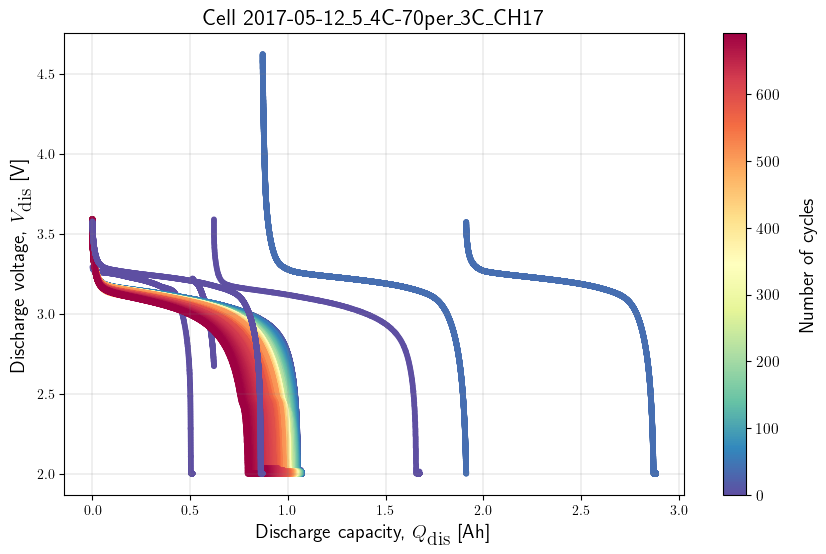

In [7]:
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
benchdb.plot_cycle_data(
    df_selected_cell_without_labels)

plt.show()

# Statistical Feature Transformation

To help with the separation of abnormal cycles from normal cycles, we propose a new statistical feature transformation method using the median and IQR of the input features:  

$$
\begin{equation}
x_\textrm{scaled} = x_i - \left[\frac{\textrm{median}(X)^{2}}{\textrm{IQR}(X)}\right],
\end{equation} 
$$

where the IQR can be calculated from the third ($75^\textrm{th}$ percentile) and first quartile ($25^\textrm{th}$ percentile) of the input vector ($\textrm{IQR}(X) = Q_3(X) - Q_1(X)$). Here, we use $\textrm{median}(X)^2$ to preserve the physical unit of the original feature after feature transformation. Feature scaling is implemented on both the capacity and voltage data.

## Capacity scaling

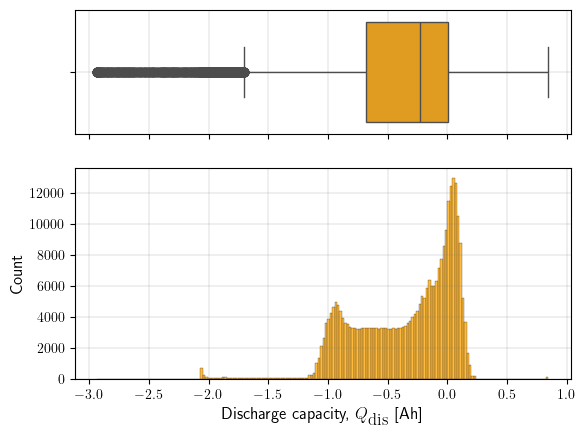

count    313326.000000
mean         -0.349626
std           0.414280
min          -2.933561
25%          -0.677412
50%          -0.226724
75%           0.005721
max           0.844670
Name: scaled_discharge_capacity, dtype: float64
**********************************************************************


0        -0.828787
1        -0.827432
2        -0.825870
3        -0.824306
4        -0.824306
            ...   
301553   -0.145985
301554   -0.145915
301555   -0.145915
301556   -0.145867
301557   -0.145867
Name: scaled_discharge_capacity, Length: 313326, dtype: float64

In [8]:
# Instantiate the CycleScaling class
scaler = CycleScaling(
    df_selected_cell=df_selected_cell_without_labels)

# Implement median IQR scaling on the discharge capacity data
df_capacity_med_scaled = scaler.median_IQR_scaling(
    variable="discharge_capacity",
    validate=True)

# Plot the histogram and boxplot of the scaled data
ax_hist = bviz.hist_boxplot(
    df_variable=df_capacity_med_scaled["scaled_discharge_capacity"])

ax_hist.set_xlabel(
    r"Discharge capacity, $Q_\textrm{dis}$ [Ah]",
    fontsize=12)
ax_hist.set_ylabel(
    r"Count",
    fontsize=12)

output_fig_filename = (
    "cap_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Print the summary statistics of the scaled capacity data
print(df_capacity_med_scaled["scaled_discharge_capacity"].describe())
print("*"*70)

df_capacity_med_scaled["scaled_discharge_capacity"]

## Voltage scaling

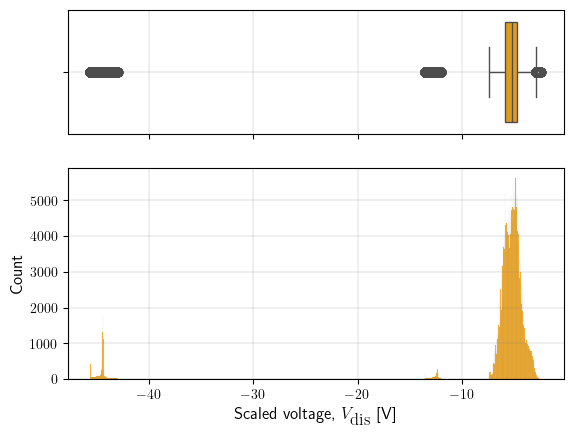

count    313326.000000
mean         -6.557421
std           7.159671
min         -45.644671
25%          -5.844655
50%          -5.215267
75%          -4.672330
max          -2.395836
Name: scaled_voltage, dtype: float64
**********************************************************************


0        -12.262836
1        -12.272870
2        -12.276842
3        -12.279593
4        -12.279593
            ...    
301553    -4.257652
301554    -4.257553
301555    -4.257553
301556    -4.257912
301557    -4.254364
Name: scaled_voltage, Length: 313326, dtype: float64

In [9]:
# Implement median IQR scaling on the discharge voltage data
df_voltage_med_scaled = scaler.median_IQR_scaling(
    variable="voltage",
    validate=True)

# Plot the histogram and boxplot of the scaled data
ax_hist = bviz.hist_boxplot(
    df_variable=df_voltage_med_scaled["scaled_voltage"])

ax_hist.set_xlabel(
    r"Scaled voltage, $V_\textrm{dis}$ [V]",
    fontsize=12)
ax_hist.set_ylabel(
    r"Count",
    fontsize=12)

output_fig_filename = (
    "voltage_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Print the summary statistics of the scaled capacity data
print(df_voltage_med_scaled["scaled_voltage"].describe())
print("*"*70)
df_voltage_med_scaled["scaled_voltage"]

## Scatter histogram

* Create scatterplot with histogram to display the distribution for x-axis and y-axis:
  * The salmon color corresponds to x-axis (``scaled_capacity``)
  * The grey color corresponds to y-axis (``scaled_voltage``)

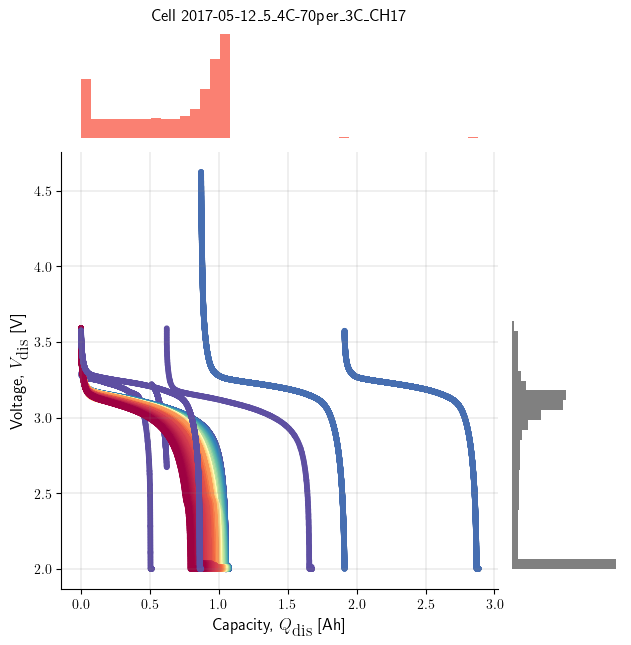

In [10]:
axplot = bviz.scatterhist(
    xseries=df_selected_cell_without_labels["discharge_capacity"],
    yseries=df_selected_cell_without_labels["voltage"],
    cycle_index_series=df_selected_cell_without_labels["cycle_index"],
    selected_cell_label=selected_cell_label)

axplot.set_xlabel(
    r"Capacity, $Q_\textrm{dis}$ [Ah]",
    fontsize=12)
axplot.set_ylabel(
    r"Voltage, $V_\textrm{dis}$ [V]",
    fontsize=12)

output_fig_filename = (
    "scatterhist_no_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

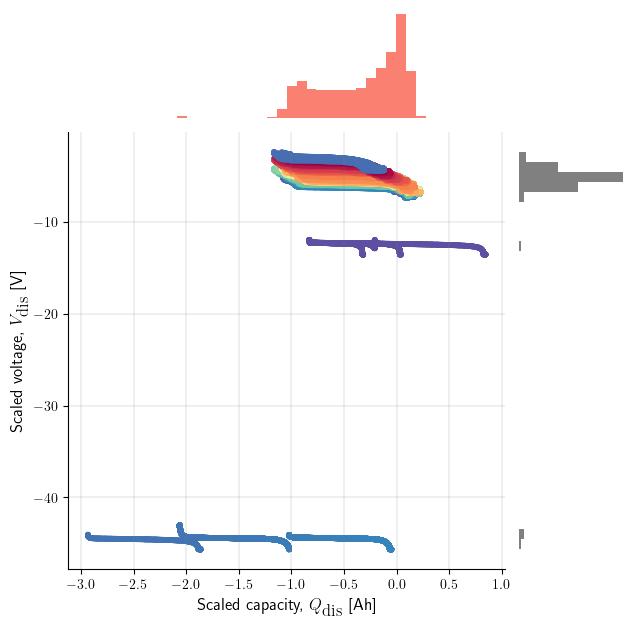

In [11]:
axplot = bviz.scatterhist(
    xseries=df_capacity_med_scaled["scaled_discharge_capacity"],
    yseries=df_voltage_med_scaled["scaled_voltage"],
    cycle_index_series=df_selected_cell_without_labels["cycle_index"])

axplot.set_xlabel(
    r"Scaled capacity, $Q_\textrm{dis}$ [Ah]",
    fontsize=12)
axplot.set_ylabel(
    r"Scaled voltage, $V_\textrm{dis}$ [V]",
    fontsize=12)

output_fig_filename = (
    "scatterhist_with_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Physics-informed Feature Extraction

* As the anomalies in this dataset are collective due to a continuous series of abnormal voltage and current measurements, we can transform the collective anomalies of a given cycle into cycle-wise point anomalies.
* Use $\Delta V$ to detect any anomalies in the voltage data
* Because our focus is on detecting anomalous cycle (multiple collective outliers and not a single data point), we are only interested in the maximum $\Delta V$ per cycle.
* Drop the first and last 10 data points to exclude instantaneous voltage jump due to voltage relaxation at the beginning and at the end because of current interruptions. These are normal voltage behaviour, not considered as anomaly. 
* If continuous abnormal voltage and current measurements are recorded in a cycle, the specific cycle will be labelled as anomalous cycle.

$$
\begin{align}
\Delta Q_\textrm{scaled,max,cyc} &= \underset{\textrm{cyc}}{\max}(Q_{\textrm{scaled},{k+1}} - Q_{\textrm{scaled},{k}}), \\
\Delta V_\textrm{scaled,max,cyc} &= \underset{\textrm{cyc}}{\max}(V_{\textrm{scaled},{k+1}} - V_{\textrm{scaled},{k}}),
\end{align} 
$$

where $\Delta V_\textrm{scaled,max,cyc}$ is the maximum scaled voltage difference per cycle and $\Delta Q_\textrm{scaled,max,cyc}$ is the maximum scaled capacity difference per cycle. $k$ in these equations denote the index of each recorded data point.

* Don't use the natural index of the dataframe as the cycle index
* Create an additional column for the cycle_index so that we can keep track of the true cycle_index even after removing some anomalous cycle from the df

## Feature max dV

In [12]:
# maximum scaled voltage difference per cycle
df_max_dV = scaler.calculate_max_diff_per_cycle(
    df_scaled=df_voltage_med_scaled,
    variable_name="scaled_voltage")

df_max_dV

,max_diff,log_max_diff,cycle_index
0,1.564151,0.447343,0.0
1,0.023727,-3.741163,1.0
2,0.022684,-3.786091,2.0
3,0.027899,-3.579172,3.0
4,0.026408,-3.634081,4.0
...,...,...,...
687,0.046420,-3.070023,687.0
688,0.051542,-2.965352,688.0
689,0.047776,-3.041228,689.0
690,0.046331,-3.071935,690.0


In [13]:
max_dV_feature_stats = bstats.calculate_feature_stats(
    df_max_dV["max_diff"],
    new_col_name="max_diff_dV")

max_dV_feature_stats

Feature mean: 0.04105323627167629
Feature max: 2.612268400000005
Feature min: 0.022684100000000207
Feature std: 0.11397361246602544
**********************************************************************


,max_diff_dV
max,2.6123
min,0.0227
mean,0.0411
std,0.1140


## Feature max dQ

In [14]:
# maximum scaled capacity difference per cycle
df_max_dQ = scaler.calculate_max_diff_per_cycle(
    df_scaled=df_capacity_med_scaled,
    variable_name="scaled_discharge_capacity")

df_max_dQ

,max_diff,log_max_diff,cycle_index
0,0.006388,-5.053343,0.0
1,0.006338,-5.061258,1.0
2,0.006321,-5.063922,2.0
3,0.006259,-5.073756,3.0
4,0.006236,-5.077346,4.0
...,...,...,...
687,0.006236,-5.077391,687.0
688,0.006281,-5.070178,688.0
689,0.006243,-5.076238,689.0
690,0.006316,-5.064619,690.0


In [15]:
max_dQ_feature_stats = bstats.calculate_feature_stats(
    df_max_dQ["max_diff"],
    new_col_name="max_diff_dQ")

max_dQ_feature_stats

Feature mean: 0.00641125672398844
Feature max: 0.042899057000000074
Feature min: 0.006194469999999952
Feature std: 0.0019646872892444154
**********************************************************************


,max_diff_dQ
max,0.0429
min,0.0062
mean,0.0064
std,0.0020


## Feature max dVdQ

In [16]:
df_max_dVdQ = scaler.calculate_max_feature_derivative_per_cycle(
    Xfeature=df_capacity_med_scaled["scaled_discharge_capacity"],
    Yfeature=df_voltage_med_scaled["scaled_voltage"],
    cycle_index=df_voltage_med_scaled["cycle_index"])

df_max_dVdQ

/home/mei-chin-pang/02_academics/osbad_development/osbad/src/osbad/scaler.py:262: RuntimeWarning: divide by zero encountered in divide
  feature_diff = numerator_feature_diff/denominator_feature_diff
/home/mei-chin-pang/02_academics/osbad_development/osbad/src/osbad/scaler.py:262: RuntimeWarning: invalid value encountered in divide
  feature_diff = numerator_feature_diff/denominator_feature_diff


,max_diff,log_max_diff,cycle_index
0,178932.163746,12.094762,0.0
1,10.879725,2.386901,1.0
2,9.355405,2.235954,2.0
3,7.779197,2.051453,3.0
4,9.119772,2.210445,4.0
...,...,...,...
687,8.897922,2.185818,687.0
688,7.007765,1.947019,688.0
689,7.087613,1.958349,689.0
690,7.316459,1.990126,690.0


In [17]:
max_dVdQ_feature_stats = bstats.calculate_feature_stats(
    df_max_dVdQ["max_diff"],
    new_col_name="max_diff_dVdQ")

max_dVdQ_feature_stats

Feature mean: 321.2474799595722
Feature max: 178932.16374587023
Feature min: 4.1214299224441175
Feature std: 6918.580867088767
**********************************************************************


,max_diff_dVdQ
max,178932.1637
min,4.1214
mean,321.2475
std,6918.5809


# Z-score method

$$
\begin{equation}
z_i = \frac{x_i - \mu}{\sigma}
\end{equation}
$$

* $x_i$ denotes the value of each data point in the feature,
* $\mu$ and $\sigma$ are the mean and Z-score of the relevant feature distribution. 

# Feature: dV

## Z-score on dV

In [18]:
# Access the dict of parameters for using 
# the Z-score method 
zscore_param_dict = bstats.outlier_method["zscore"].params
print(zscore_param_dict)

# Predict the anomalous cycle using z-score method 
# and the corresponding stats parameters
(zscore_outlier_dV_index,
 zscore_min_limit_dV,
 zscore_max_limit_dV) = bstats.outlier_method["zscore"].compute(
    df_max_dV["max_diff"], 
    **zscore_param_dict)

print("*"*70)
print(df_max_dV[df_max_dV["cycle_index"].isin(zscore_outlier_dV_index)])
print("*"*70)

{'zscore_threshold': 3.0, 'ddof': 1}
Feature mean: 0.04105323627167629
Feature std: 0.11397361246602544
----------------------------------------------------------------------
After Z-transformation, feature mean should be close to 0 and feature std should be close to 1.
Zscore feature mean: 9.626211196171877e-19
Zscore feature std: 1.0
Zscore anomalous cycle index: (array([ 0, 40]),)
**********************************************************************
    max_diff  log_max_diff  cycle_index
0   1.564151      0.447343          0.0
40  2.612268      0.960219         40.0
**********************************************************************


## Exclude Z-score predicted outliers

* Exclude voltage outliers predicted by Z-score

In [19]:
df_voltage_2iter = df_voltage_med_scaled[
    ~df_voltage_med_scaled["cycle_index"]
        .isin(zscore_outlier_dV_index)]

df_max_dV_2nd_iter = scaler.calculate_max_diff_per_cycle(
    df_scaled=df_voltage_2iter,
    variable_name="scaled_voltage")

df_max_dV_2nd_iter

,max_diff,log_max_diff,cycle_index
0,0.023727,-3.741163,1.0
1,0.022684,-3.786091,2.0
2,0.027899,-3.579172,3.0
3,0.026408,-3.634081,4.0
4,0.024357,-3.714944,5.0
...,...,...,...
685,0.046420,-3.070023,687.0
686,0.051542,-2.965352,688.0
687,0.047776,-3.041228,689.0
688,0.046331,-3.071935,690.0


## Feature normality check

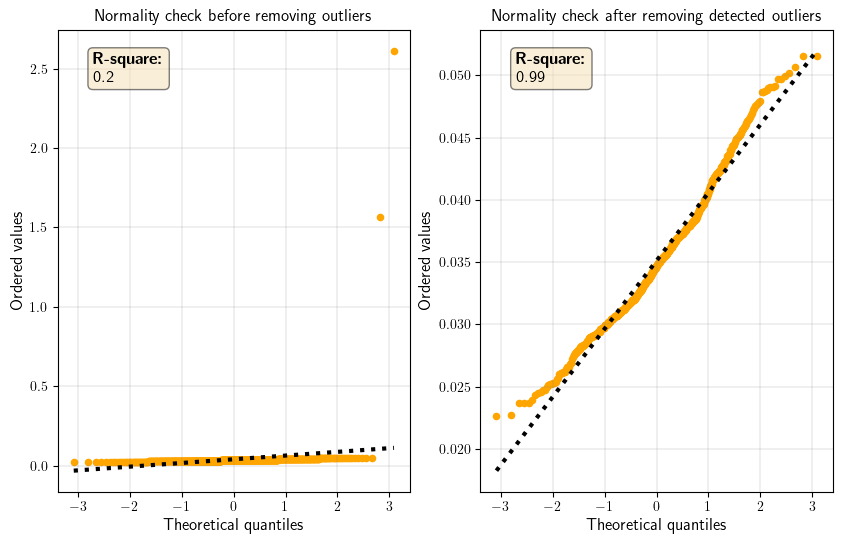

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1 = bviz.plot_quantiles(
    xdata=df_max_dV["max_diff"],
    ax=ax1,
    fit=True,
    validate=False)

ax1.set_title(
    "Normality check before removing outliers")


ax2 = bviz.plot_quantiles(
    xdata=df_max_dV_2nd_iter["max_diff"],
    ax=ax2,
    fit=True,
    validate=False)

ax2.set_title(
    "Normality check after removing detected outliers")

output_fig_filename = (
    "zscore_normality_check_dV_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Distribution fit

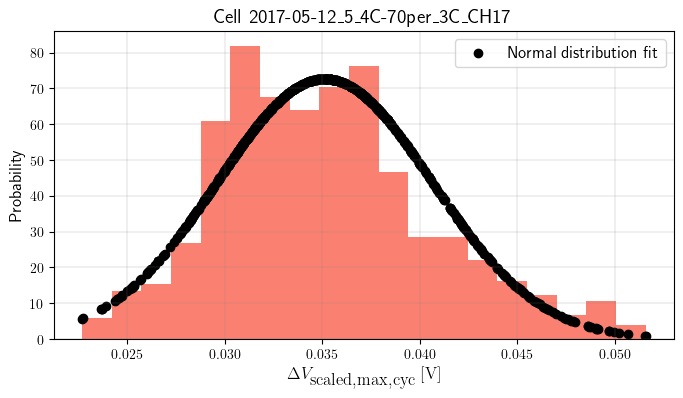

In [21]:
axplot = bviz.plot_histogram_with_distribution_fit(
    df_variable=df_max_dV_2nd_iter["max_diff"],
    method="norm")

axplot.set_xlabel(
    r"$\Delta V_\textrm{scaled,max,cyc}\;\textrm{[V]}$",
    fontsize=12)

axplot.set_ylabel('Probability', fontsize=12)

axplot.set_title(
    f"Cell {selected_cell_label}",
    fontsize=14)

output_fig_filename = (
    "zscore_dV_dist_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Bubble plot

Feature mean: 0.04105323627167629
Feature max: 2.612268400000005
Feature min: 0.022684100000000207
Feature std: 0.11397361246602544
**********************************************************************
Potential anomalous cycle: 0.0
x-position of the text: 0.0
y-position of the text: 1.5641508000000002
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: 40.0
y-position of the text: 2.612268400000005
----------------------------------------------------------------------


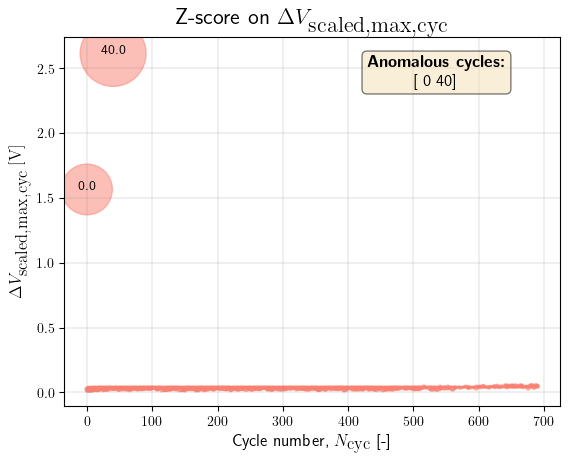

In [22]:
unique_cycle_count = (
    df_selected_cell_without_labels["cycle_index"]
    .unique())

df_bubble_size_dV = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dV["max_diff"])

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=df_max_dV["max_diff"],
    bubble_size=df_bubble_size_dV,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=zscore_outlier_dV_index)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$\Delta V_\textrm{scaled,max,cyc}\;\textrm{[V]}$",
    fontsize=12)

fig_title=(r"Z-score on $\Delta V_\textrm{scaled,max,cyc}$")

axplot.set_title(
    fig_title,
    fontsize=16)

output_fig_filename = (
    "zscore_dv_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Confusion matrix

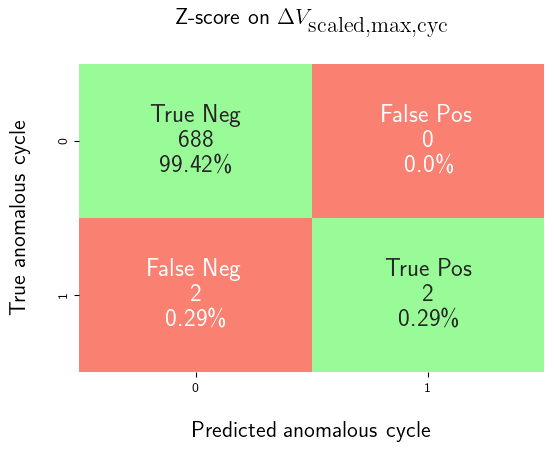

In [23]:
# Compare Z-score predicted anomalies with true anomalies
df_eval_outlier_zscore_dV = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=zscore_outlier_dV_index)

# Generate custom confusion matrix
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_zscore_dV["true_outlier"],
    y_pred=df_eval_outlier_zscore_dV["pred_outlier"])

fig_title=(r"Z-score on $\Delta V_\textrm{scaled,max,cyc}$ \newline")

axplot.set_title(
    fig_title 
    + "\n",
    fontsize=16)

output_fig_filename = (
    "zscore_conf_matrix_dv_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Feature: dQ

## Z-score on dQ

In [24]:
zscore_param_dict = bstats.outlier_method["zscore"].params
print(zscore_param_dict)

(zscore_outlier_dQ_index,
 zscore_min_limit_dQ,
 zscore_max_limit_dQ) = bstats.outlier_method["zscore"].compute(
    df_max_dQ["max_diff"], 
    **zscore_param_dict)

print("*"*70)
print(df_max_dQ[df_max_dQ["cycle_index"].isin(zscore_outlier_dQ_index)])
print("*"*70)

{'zscore_threshold': 3.0, 'ddof': 1}
Feature mean: 0.00641125672398844
Feature std: 0.0019646872892444154
----------------------------------------------------------------------
After Z-transformation, feature mean should be close to 0 and feature std should be close to 1.
Zscore feature mean: 2.3102906870812504e-16
Zscore feature std: 1.0
Zscore anomalous cycle index: (array([147, 148]),)
**********************************************************************
     max_diff  log_max_diff  cycle_index
147  0.042814     -3.150895        147.0
148  0.042899     -3.148905        148.0
**********************************************************************


## Exclude Z-score predicted outliers

* Exclude capacity outliers predicted by Z-score

In [25]:
df_cap_2iter = df_capacity_med_scaled[
    ~df_capacity_med_scaled["cycle_index"]
        .isin(zscore_outlier_dQ_index)]

df_max_dQ_2nd_iter = scaler.calculate_max_diff_per_cycle(
    df_scaled=df_cap_2iter,
    variable_name="scaled_discharge_capacity")

df_max_dQ_2nd_iter

,max_diff,log_max_diff,cycle_index
0,0.006388,-5.053343,0.0
1,0.006338,-5.061258,1.0
2,0.006321,-5.063922,2.0
3,0.006259,-5.073756,3.0
4,0.006236,-5.077346,4.0
...,...,...,...
685,0.006236,-5.077391,687.0
686,0.006281,-5.070178,688.0
687,0.006243,-5.076238,689.0
688,0.006316,-5.064619,690.0


## Feature normality check

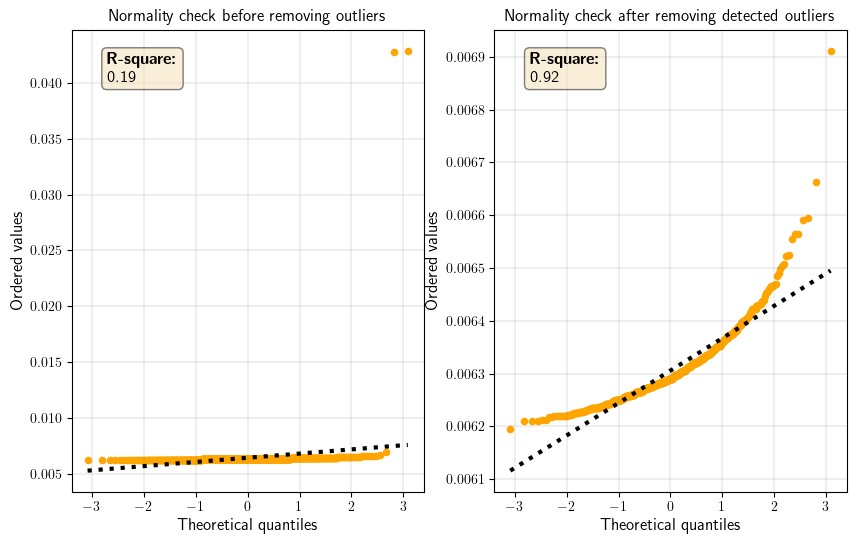

In [26]:
# Reset the sns settings
# from confusion matrix
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams["text.usetex"] = True

fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(10, 6))

axplot1 = bviz.plot_quantiles(
    xdata=df_max_dQ["max_diff"],
    ax=ax1,
    fit=True,
    validate=False)

axplot1.set_title(
    "Normality check before removing outliers")

axplot2 = bviz.plot_quantiles(
    xdata=df_max_dQ_2nd_iter["max_diff"],
    ax=ax2,
    fit=True,
    validate=False)

axplot2.set_title(
    "Normality check after removing detected outliers")

output_fig_filename = (
    "zscore_normality_check_dq_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Distribution fit

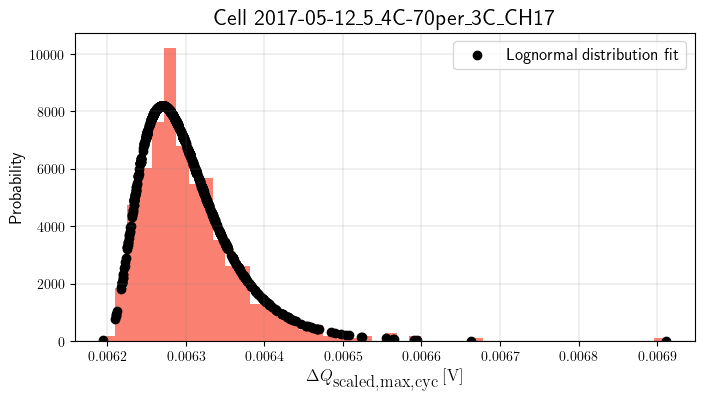

In [27]:
axplot = bviz.plot_histogram_with_distribution_fit(
    df_variable=df_max_dQ_2nd_iter["max_diff"],
    method="lognorm")

axplot.set_xlabel(
    r"$\Delta Q_\textrm{scaled,max,cyc}\;\textrm{[V]}$",
    fontsize=12)

axplot.set_ylabel('Probability', fontsize=12)

axplot.set_title(
    f"Cell {selected_cell_label}",
    fontsize=16)

output_fig_filename = (
    "zscore_dq_dist_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Yeo-Johnson transformation

As the statistical anomaly detection methods based on standard deviation and Z-score require the data to be normally distributed, these two methods cannot be applied directly on the feature $\Delta Q_\textrm{scaled,max,cyc}$ with a lognormal distribution. In this case, we further used the Yeo-Johnson power transformation to reduce the skewness in the feature:

$$
\begin{equation}
y^{\lambda} = \left \{\begin{array}{rcl} ((y+1)^{\lambda} - 1)/\lambda & \mbox{if} \ & {\lambda \neq 0,\; y \geq 0}, \\
\log(y+1) & \mbox{if} \ & {\lambda = 0,\; y \geq 0}, \\ 
- [(-y+1)^{2-\lambda} - 1)]/(2-\lambda) & \mbox{if} \ & {\lambda \neq 2,\; y < 0}, \\
-\log(-y+1) & \mbox{if} \ & {\lambda = 2,\; y < 0}, \\ 
\end{array} \right.
\end{equation}
$$

where $y$ is equivalent to selected non-Gaussian feature in this work. The value of $\lambda$ is automatically tuned from the ``scipy.stats`` library by maximizing the log-likelihood function. The following plots compare the effects before and after applying Yeo-Johnson transformation to the feature $\Delta Q_\textrm{scaled,max,cyc}$. The skewness has been reduced to better reflect a normal distribution fit.

**Note:** This step is optional and not needed if the original feature distribution is Gaussian-like.

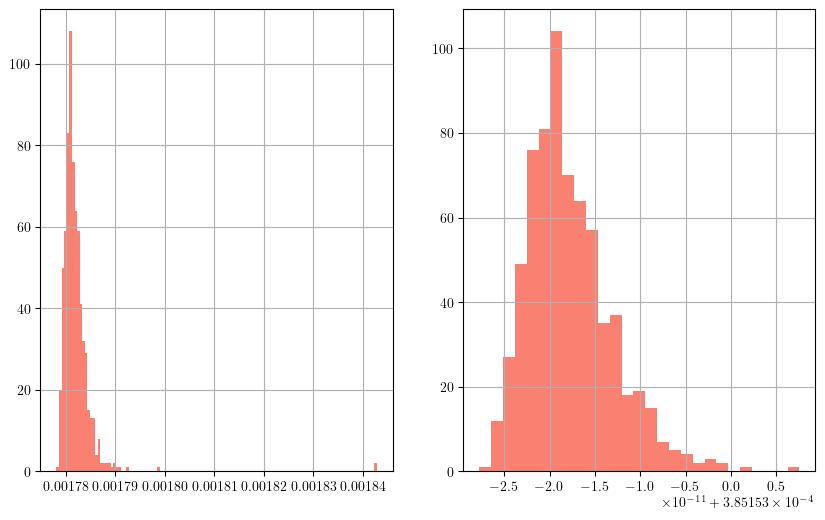

In [28]:
from scipy.stats import yeojohnson

yftarget, lambda_yj = yeojohnson(
    df_max_dQ["max_diff"])
yftarget_2nditer, lambda_yj_2nditer = yeojohnson(
    df_max_dQ_2nd_iter["max_diff"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.hist(yftarget, bins="auto", color="salmon")
ax1.grid()

ax2.hist(yftarget_2nditer, bins="auto", color="salmon")
ax2.grid()

plt.show()

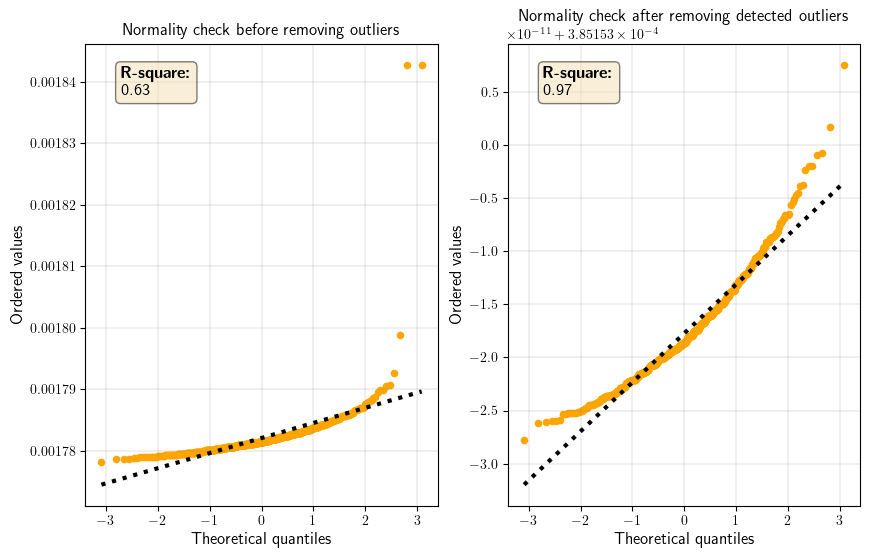

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

axplot1 = bviz.plot_quantiles(
    xdata=yftarget,
    ax=ax1,
    fit=True,
    validate=False)

axplot1.set_title(
    "Normality check before removing outliers")

axplot2 = bviz.plot_quantiles(
    xdata=yftarget_2nditer,
    ax=ax2,
    fit=True,
    validate=False)

axplot2.set_title(
    "Normality check after removing detected outliers")

output_fig_filename = (
    "zscore_normality_check_yj_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

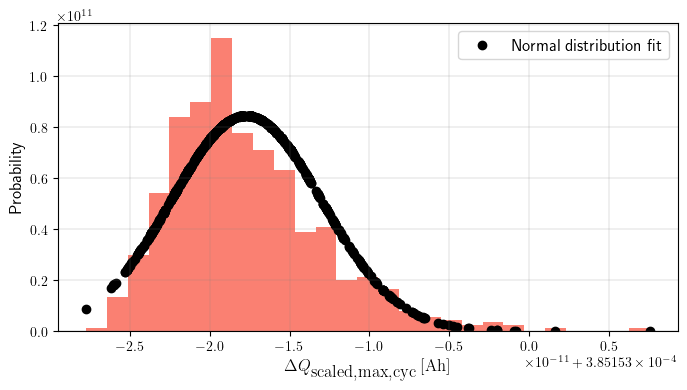

In [30]:
axplot = bviz.plot_histogram_with_distribution_fit(
    df_variable=yftarget_2nditer,
    method="norm")

axplot.set_xlabel(
    r"$\Delta Q_\textrm{scaled,max,cyc}\;\textrm{[Ah]}$",
    fontsize=12)
axplot.set_ylabel('Probability', fontsize=12)

output_fig_filename = (
    "zscore_dq_dist_yj_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

In [31]:
zscore_param_dict = bstats.outlier_method["zscore"].params
print(zscore_param_dict)

(zscore_outlier_dQ_yj_index,
 zscore_min_limit_yj_dQ,
 zscore_max_limit_yj_dQ) = bstats.outlier_method["zscore"].compute(
    yftarget, 
    **zscore_param_dict)

{'zscore_threshold': 3.0, 'ddof': 1}
Feature mean: 0.00178207229146437
Feature std: 3.884645458677975e-06
----------------------------------------------------------------------
After Z-transformation, feature mean should be close to 0 and feature std should be close to 1.
Zscore feature mean: -1.6120695016522505e-15
Zscore feature std: 0.9999999999999998
Zscore anomalous cycle index: (array([ 32, 147, 148]),)


## Bubble plot

Feature mean: 0.00178207229146437
Feature max: 0.0018427543856272667
Feature min: 0.001778177433199892
Feature std: 3.884645458677975e-06
**********************************************************************
Potential anomalous cycle: 32.0
x-position of the text: 32.0
y-position of the text: 0.0017988887105165308
----------------------------------------------------------------------
Potential anomalous cycle: 147.0
x-position of the text: 147.0
y-position of the text: 0.0018427543856167285
----------------------------------------------------------------------
Potential anomalous cycle: 148.0
x-position of the text: 148.0
y-position of the text: 0.0018427543856272667
----------------------------------------------------------------------


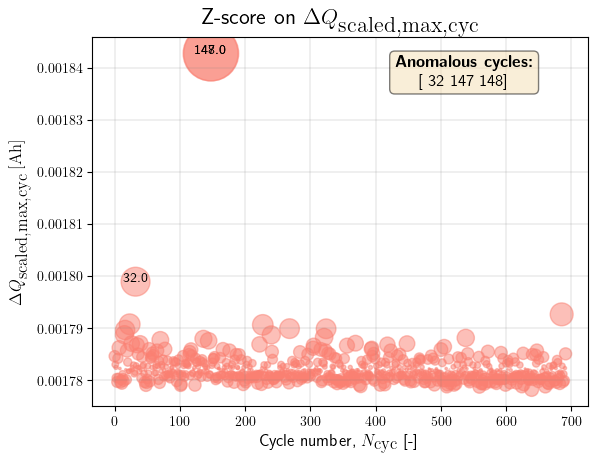

In [32]:
yftarget_without_log, lambda_yj_without_log = yeojohnson(
    df_max_dQ["max_diff"])

df_bubble_size_dQ_yj = bviz.calculate_bubble_size_ratio(
    df_variable=yftarget_without_log)

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=yftarget,
    bubble_size=df_bubble_size_dQ_yj,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=zscore_outlier_dQ_yj_index)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$\Delta Q_\textrm{scaled,max,cyc}\;\textrm{[Ah]}$",
    fontsize=12)

fig_title=(r"Z-score on $\Delta Q_\textrm{scaled,max,cyc}$")

axplot.set_title(
    fig_title,
    fontsize=16)

output_fig_filename = (
    "zscore_dq_yj_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Confusion matrix

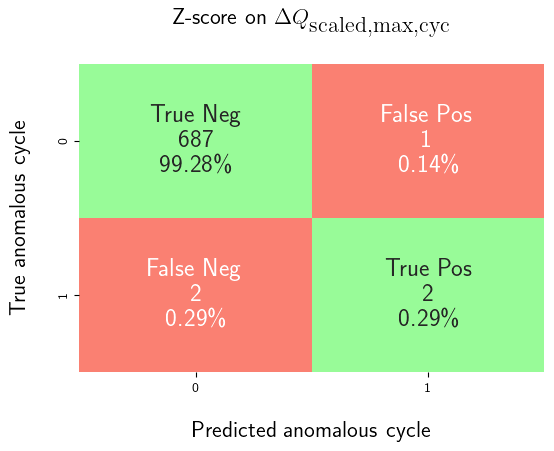

In [33]:
df_eval_outlier_zscore_dQ = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=zscore_outlier_dQ_yj_index)

axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_zscore_dQ["true_outlier"],
    y_pred=df_eval_outlier_zscore_dQ["pred_outlier"])

fig_title=(
    r"Z-score on $\Delta Q_\textrm{scaled,max,cyc}$ \newline")

axplot.set_title(
    fig_title + "\n", fontsize=16)

output_fig_filename = (
    "zscore_conf_matrix_dq_yj_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Feature: dVdQ

## Z-score on log(dVdQ)

In [34]:
zscore_param_dict = bstats.outlier_method["zscore"].params
print(zscore_param_dict)

(zscore_outlier_dVdQ_index,
 zscore_min_limit_dVdQ,
 zscore_max_limit_dVdQ) = bstats.outlier_method["zscore"].compute(
    df_max_dVdQ["log_max_diff"], 
    **zscore_param_dict)

{'zscore_threshold': 3.0, 'ddof': 1}
Feature mean: 2.5595374236183797
Feature std: 0.6559262319497828
----------------------------------------------------------------------
After Z-transformation, feature mean should be close to 0 and feature std should be close to 1.
Zscore feature mean: -2.566989652312501e-16
Zscore feature std: 1.0
Zscore anomalous cycle index: (array([ 0, 40]),)


## Exclude Z-score predicted outliers

In [35]:
df_dVdQ_2iter = df_max_dVdQ[
    ~df_max_dVdQ["cycle_index"].isin(
        zscore_outlier_dVdQ_index)]

df_dVdQ_2iter

,max_diff,log_max_diff,cycle_index
1,10.879725,2.386901,1.0
2,9.355405,2.235954,2.0
3,7.779197,2.051453,3.0
4,9.119772,2.210445,4.0
5,8.187879,2.102655,5.0
...,...,...,...
687,8.897922,2.185818,687.0
688,7.007765,1.947019,688.0
689,7.087613,1.958349,689.0
690,7.316459,1.990126,690.0


## Feature normality check

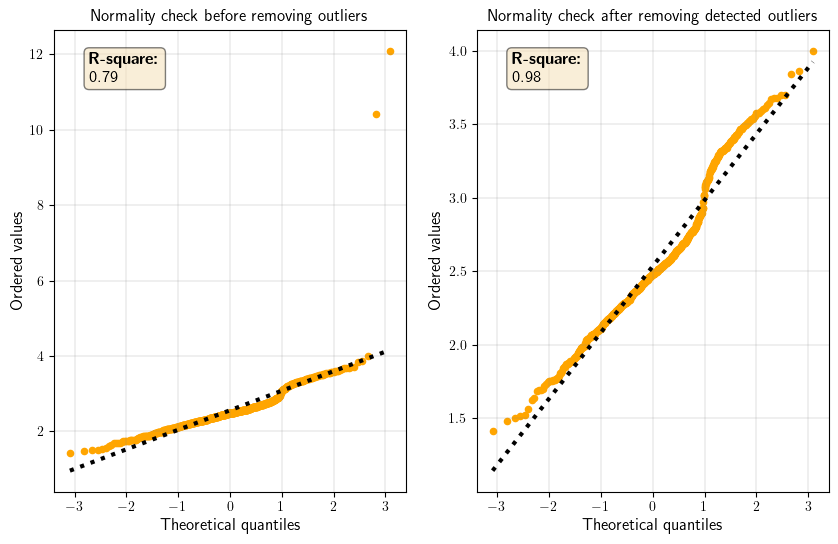

In [36]:
# Reset the sns settings
# from confusion matrix
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams["text.usetex"] = True

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

axplot1 = bviz.plot_quantiles(
    xdata=df_max_dVdQ["log_max_diff"],
    ax=ax1,
    fit=True,
    validate=False)

axplot1.set_title("Normality check before removing outliers")

axplot2 = bviz.plot_quantiles(
    xdata=df_dVdQ_2iter["log_max_diff"],
    ax=ax2,
    fit=True,
    validate=False)

axplot2.set_title("Normality check after removing detected outliers")

output_fig_filename = (
    "zscore_normality_check_dvdq_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Distribution fit

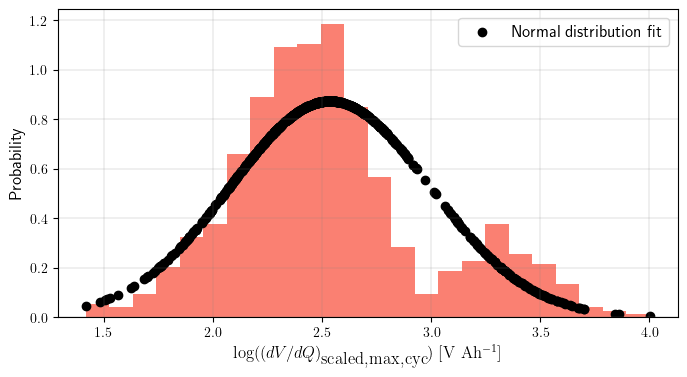

In [37]:
axplot = bviz.plot_histogram_with_distribution_fit(
    df_variable=np.array(df_dVdQ_2iter["log_max_diff"]),
    method="norm")

axplot.set_xlabel(
    r"$\log((dV/dQ)_\textrm{scaled,max,cyc})\;\textrm{[V Ah$^{-1}$]}$",
    fontsize=12)
axplot.set_ylabel('Probability', fontsize=12)

axplot.legend(
    loc="upper right",
    fontsize=12)

output_fig_filename = (
    "zscore_dvdq_dist_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Bubble plot

Feature mean: 321.2474799595722
Feature max: 178932.16374587023
Feature min: 4.1214299224441175
Feature std: 6918.580867088767
**********************************************************************
Potential anomalous cycle: 0.0
x-position of the text: 0.0
y-position of the text: 178932.16374587023
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: 40.0
y-position of the text: 33622.15384614415
----------------------------------------------------------------------


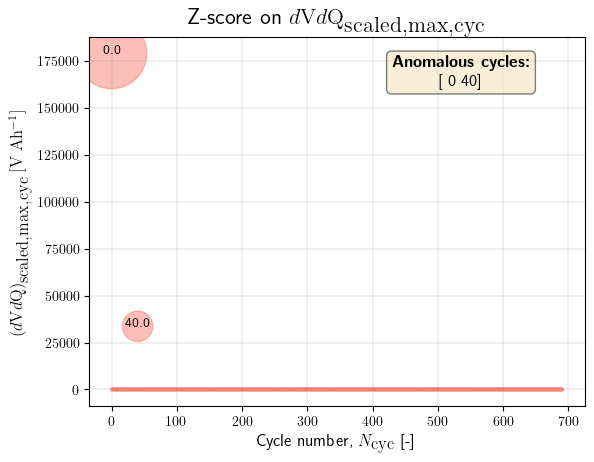

In [38]:
df_bubble_size_dVdQ = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dVdQ["max_diff"])

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=df_max_dVdQ["max_diff"],
    bubble_size=df_bubble_size_dVdQ,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=zscore_outlier_dVdQ_index)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$(d\textrm{V}d\textrm{Q})_\textrm{scaled,max,cyc}\;\textrm{[V Ah$^{-1}$]}$",
    fontsize=12)

fig_title=(
    r"Z-score on $d\textrm{V}d\textrm{Q}_\textrm{scaled,max,cyc}$ \newline")

axplot.set_title(
    fig_title,
    fontsize=16)

output_fig_filename = (
    "zscore_dvdq_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Confusion matrix

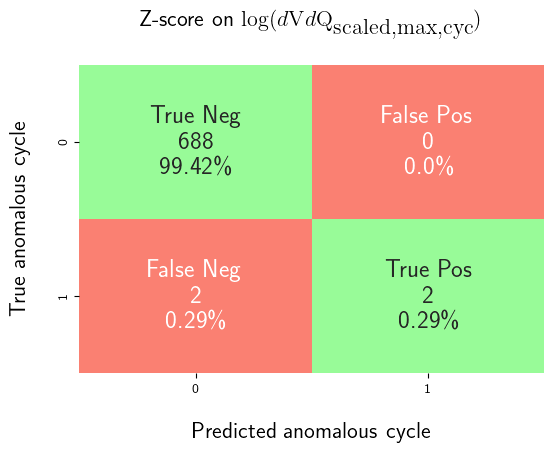

In [39]:
# Compare Z-score predicted anomalies on the feature dVdQ
# with the true anomalies from the benchmarking dataset
df_eval_outlier_zscore_dVdQ = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=zscore_outlier_dVdQ_index)

fig_title=(
    r"Z-score on $\log(d\textrm{V}d\textrm{Q}_\textrm{scaled,max,cyc})$ \newline")

axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_zscore_dVdQ["true_outlier"],
    y_pred=df_eval_outlier_zscore_dVdQ["pred_outlier"])

axplot.set_title(
    fig_title + "\n", fontsize=16)

output_fig_filename = (
    "zscore_conf_matrix_dvdq_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Visualize potential anomalous cycles

## Multiple anomalous cycles

* Plot and annotate multiple potential outlier cycles.

Total subplot: 4
Total rows: 1
Total columns: 4
**********************************************************************
Plot outlier cycle: 0
Plot outlier cycle: 40
Plot outlier cycle: 147
Plot outlier cycle: 148


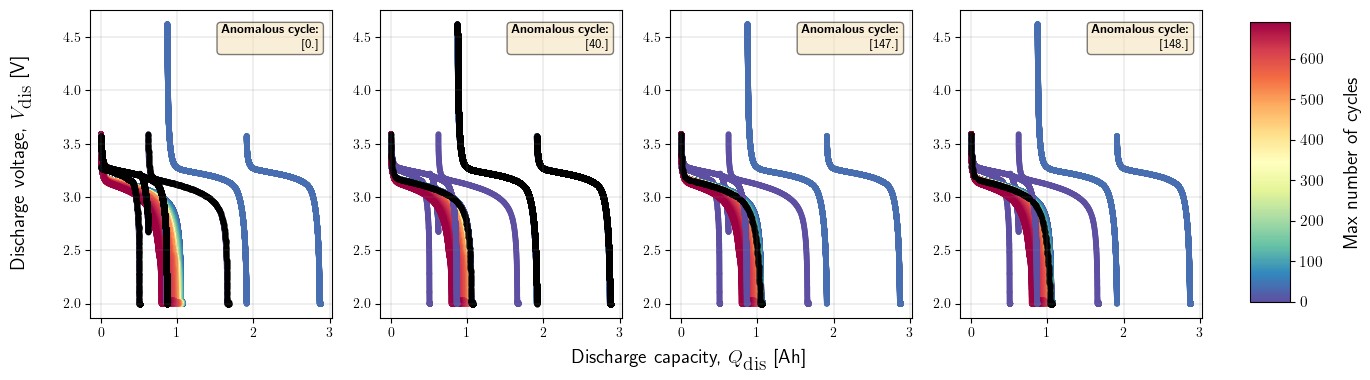

In [40]:
bviz.plot_multiple_outlier_cycles(
    df_selected_cell,
    potential_outlier_cycles= [0, 40, 147, 148],
    selected_cell_label=selected_cell_label)

## Single anomalous cycle

* Plot and annotate a single cycle as a potential outlier.

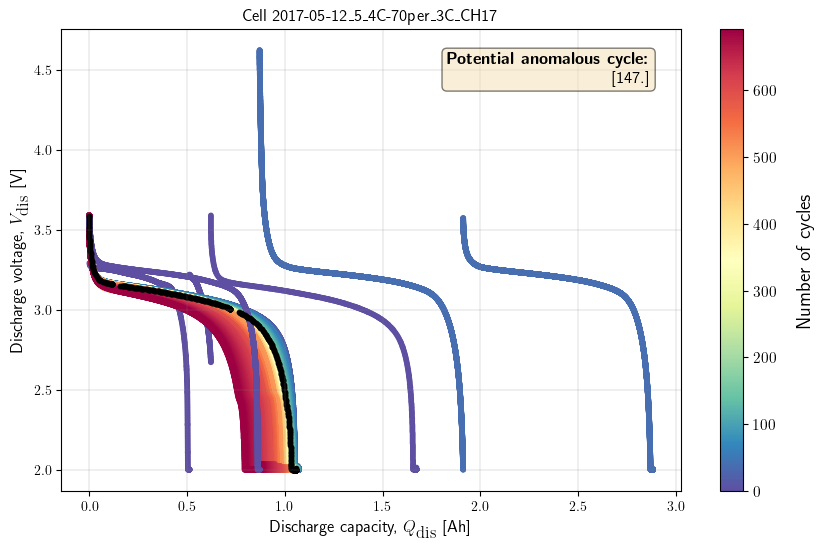

In [41]:
bviz.plot_single_outlier_cycle(
    df_selected_cell,
    selected_cycle_index=147,
    selected_cell_label=selected_cell_label)

# Plot cycle data with true outliers

In [42]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)

    # print a subset of the dataframe
    # for diagnostics running in terminals
    print(df_selected_cell_without_labels.head(10).to_markdown())
    print("*"*100)

    # Extract true outliers cycle index from benchmarking dataset
    true_outlier_cycle_index = benchdb.get_true_outlier_cycle_index(
        df_selected_cell)
    print(f"True outlier cycle index:")
    print(true_outlier_cycle_index)

Database is found in the given filepath.
Loading benchmarking dataset now...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

****************************************************************************************************
|    | cell_index                    |   cycle_index |   discharge_capacity |   voltage |
|---:|:------------------------------|--------------:|---------------------:|----------:|
|  0 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          1.26512e-05 |   3.29189 |
|  1 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00136774  |   3.28185 |
|  2 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00292998  |   3.27788 |
|  3 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  4 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  5 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00605927  |   3.27299 |
|  6 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00762155  |   3.27124 |
|  7 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.0091859   |   3.2703  |

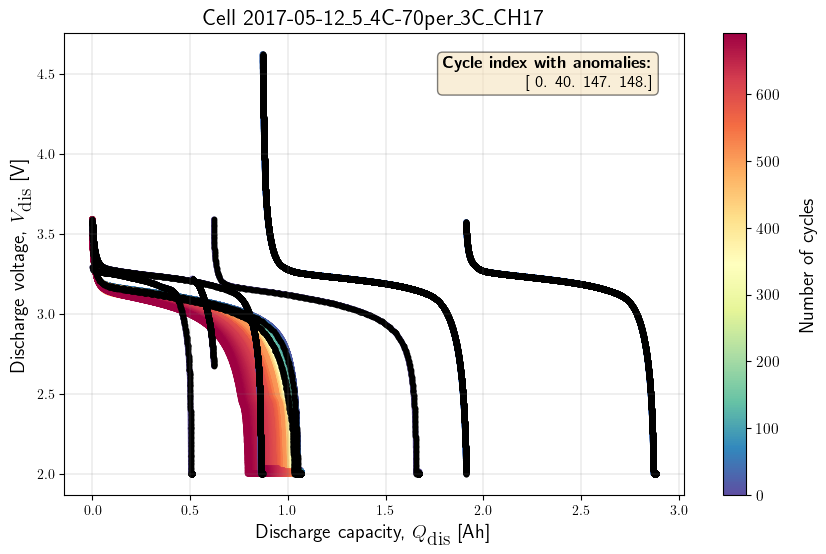

In [43]:
# Plot cell data with true anomalies
benchdb.plot_cycle_data(
    df_selected_cell_without_labels,
    true_outlier_cycle_index)

plt.show()